# Data collection

After following the installation, attach your camera to the robot end effector. Place your items on the table.

1. Launch the camera with `roslaunch dvs_renderer davis_mono.launch`
2. Play around with the lens the parameters in the settings menu of the camera until the image and events are clear and not blurry
3. Bringup the robot via `roslaunch ros_robot_pkg bringup_robot.launch` and use the `data_collection.py` file to collect data. Collect data at both full light and low light conditions. Record data by running `rosbag record /dvs/events /dvs/image_raw /tcp_pose /tcp/vel -O workshop.bag`
4. Run the the bag through the bag_to_h5.py file and proceed with this notebook.

# Loading data

In [1]:
import h5py
import numpy as np
import tonic

h5 = h5py.File('/home/aric/neuromorphic_workshop/workshop1.h5', 'r')

events = h5['events_data'][:]
print(events.shape)

def arr_to_struct(arr): 
    #we will cover tonic later. For now just know that it is a format for storing events that is more memory efficient.
    out = np.zeros(len(arr), dtype=[('x', '<i2'), ('y', '<i2'), ('p', '?'), ('t', '<f8')])
    arr[:, 3] = arr[:, 3] * 1e6
    arr[:, 3] = arr[:, 3] - arr[0, 3]
    
    out['x'] = arr[:, 0].astype(np.int16)
    out['y'] = arr[:, 1].astype(np.int16)
    out['p'] = arr[:, 2].astype(bool)
    out['t'] = arr[:, 3].astype(np.float64)
    return out

events = arr_to_struct(events)

(460378, 4)


In [2]:
#first and last 5 events
print("First 5 events:")
print(events[:5])
print("Last 5 events:")
print(events[-5:])

First 5 events:
[(208, 133,  True,    0.  ) (233, 242, False,  445.75)
 (334, 217, False, 1755.  ) (208, 133, False, 2859.  )
 (327,  71,  True, 2966.  )]
Last 5 events:
[( 93, 131, False, 10495554.  ) (297, 153, False, 10496110.  )
 (208, 223, False, 10496373.  ) (277, 145,  True, 10496699.75)
 (271, 101,  True, 10499892.  )]


In [3]:
events

array([(208, 133,  True, 0.00000000e+00),
       (233, 242, False, 4.45750000e+02),
       (334, 217, False, 1.75500000e+03), ...,
       (208, 223, False, 1.04963730e+07),
       (277, 145,  True, 1.04966998e+07),
       (271, 101,  True, 1.04998920e+07)],
      dtype=[('x', '<i2'), ('y', '<i2'), ('p', '?'), ('t', '<f8')])

## Event processing preliminary
Event-based data can be thought of as an irregularly sampled time series. Depending on the problem at hands, there are several ways of processing event camera data. We begin by first visualizing what event-based data is.

A natural way of doing so is to look at the 3D plots of the events. We can look at 30ms windows.

In [6]:
events['t'] *1e-6

array([0.00000000e+00, 4.45750000e-04, 1.75500000e-03, ...,
       1.04963730e+01, 1.04966997e+01, 1.04998920e+01])

In [10]:
np.where((events['t']*1e-6 >= 4) & (events['t']*1e-6 <= 5))[0].shape

(90736,)

Time span:  10.499892 seconds
Number of 30 ms windows:  349


Text(0, 0.5, 'Number of events')

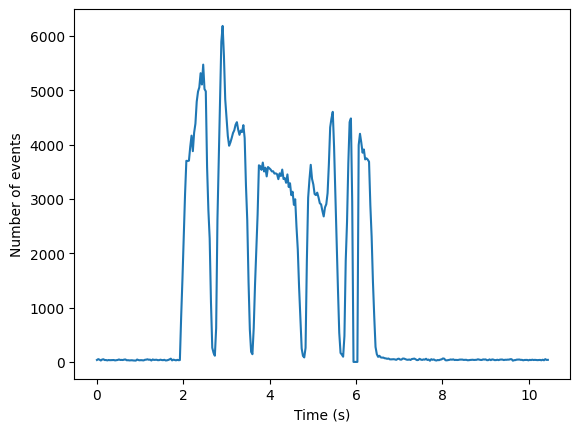

In [4]:
import matplotlib.pyplot as plt
ts0 = events[0]['t']
ts1 = events[-1]['t']

print("Time span: ", (ts1 - ts0) / 1e6, "seconds")

#30 ms windows
breaks = np.arange(ts0, ts1, 30e3)
print("Number of 30 ms windows: ", len(breaks) - 1)

#count events in each window
#we can exploit the fact that the events are sorted by time by using numpy's searchsorted function to search for the indices of the breaks in the events array
breaks_idx = np.searchsorted(events['t'], breaks)
counts = np.diff(breaks_idx)

plt.plot(breaks[:-1] / 1e6, counts, label='Events per 30 ms')
plt.xlabel('Time (s)')
plt.ylabel('Number of events')

Your job now is to try and reproduce some the event-representations you saw in the slides on one of the 30ms windows you found above. 

## Reproduce the 3D plot

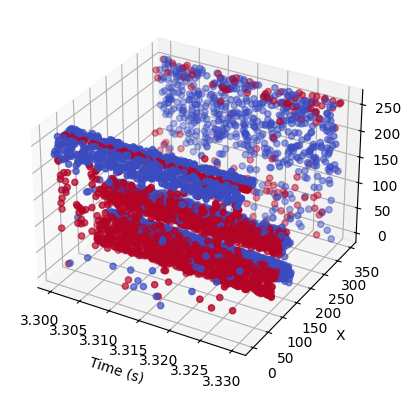

In [5]:
import matplotlib.pyplot as plt
# %matplotlib qt
#3D plot the events
window_idx = 110
sample = events[breaks_idx[window_idx]:breaks_idx[window_idx + 1]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['t'] / 1e6, sample['x'], sample['y'], c=sample['p'], cmap='coolwarm')
ax.set_xlabel('Time (s)')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.show()


## Reproduce the histogram without polarity

In [ ]:
#code to produce event frame histogram

## Reproduce the voxel grid with 4 bins

In [9]:
#code to produce voxel grid

## Reproduce the average timestamps

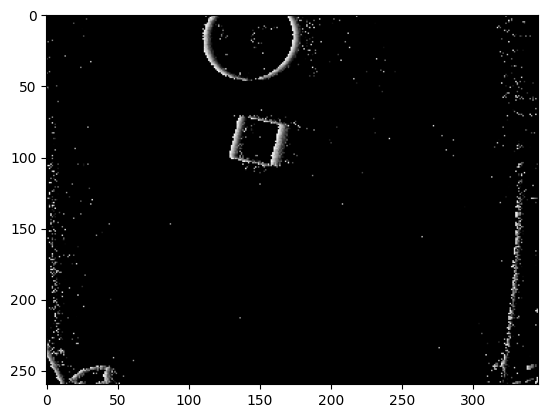

In [21]:
%matplotlib inline

sample = events[breaks_idx[window_idx]:breaks_idx[window_idx + 1]]

F = np.zeros((260, 346, 1))
counts = np.zeros((260, 346, 1))

t_norm = (sample['t'] - sample['t'][0]) / (sample['t'][-1] - sample['t'][0])

for i, e in enumerate(sample):
    F[e['y'], e['x'], 0] = F[e['y'], e['x'], 0] + t_norm[i]
    counts[e['y'], e['x'], 0] = counts[e['y'], e['x'], 0] + 1

F = np.divide(F, counts, out=np.zeros_like(F), where=counts != 0)

plt.imshow(F[:, :, 0], cmap='gray')

In [22]:
F.max()

1.0

In [18]:
sample['t']

array([3300007.75, 3300016.  , 3300017.  , ..., 3329981.  , 3329984.  ,
       3329999.  ])

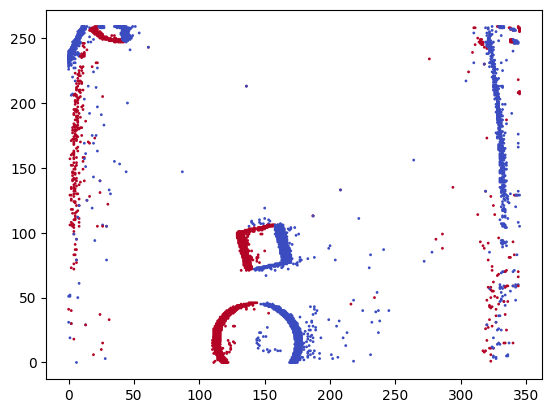

In [15]:
plt.scatter(sample['x'], sample['y'], c=sample['p'], cmap='coolwarm', s=1)

In [13]:
t_norm

array([0.00000000e+00, 2.75080232e-04, 3.08423290e-04, ...,
       9.99399825e-01, 9.99499854e-01, 1.00000000e+00])